In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

matplotlib.rcParams.update({'font.size': 16,
                            'xtick.labelsize': 12,
                            'ytick.labelsize': 12})

# Analyzing the flexible path length simulation

Load the file, and from the file pull our the engine (which tells us what the timestep was) and the move scheme (which gives us a starting point for much of the analysis).

In [2]:
filename = "alanine_dipeptide_tps.nc"

Opening a large storage file can take some time. In addition, the `AnalysisStorage` object tries to pre-cache things, which makes opening it take longer, but can make analysis faster.

In [4]:
%%time
flexible = paths.Storage(filename, mode='r')

CPU times: user 2.45 s, sys: 205 ms, total: 2.66 s
Wall time: 3.44 s


In [5]:
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [6]:
print("File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots),
))

File size: 110.33MB for 1001 steps, 46704 snapshots


That tell us a little about the file we're dealing with. Note that the number of snapshots listed is twice the number of configurations. That's because every snapshot object stores a virtual version of its velocity-reversed copy. Both share the same configuration and velocity storage; one just flips the signs on the velocities.

Now we'll start analyzing the contents of that file. We used a very simple move scheme (only shooting), so the main information that the `move_summary` gives us is the acceptance of the only kind of move in that scheme. See the MSTIS examples for more complicated move schemes, where you want to make sure that frequency at which the move runs is close to what was expected.

In [7]:
%%time
flex_scheme.move_summary(flexible.steps)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 793/1000 (79.30%)
CPU times: user 1min 34s, sys: 10.2 s, total: 1min 45s
Wall time: 1min 46s


#### Replica history tree and decorrelated trajectories

The `PathTree` object gives us both the history tree (often called the "move tree") and the number of decorrelated trajectories. It takes the history of a given replica (in our case, replica 0, the only one) and builds a description of the move history.

A `PathTree` is made for a certain set of Monte Carlo steps. First, we make a tree of only the first 20 steps in order to visualize it. (All 10000 steps would be unwieldy.) Note that only the accepted steps are shown by default (see examples for path tree visualization for customization details.)

After the visualization, we make a second `PathTree` of all the steps, in order to count the number of decorrelated trajectories.

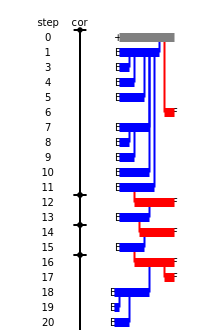

In [8]:
tree = ops_vis.PathTree(
    flexible.steps[0:21],
    ops_vis.ReplicaEvolution(
        replica=0
    )
)

with open("flexible_path_tree.svg", mode='w') as f:
    f.write(tree.svg())

SVG(tree.svg())

In [10]:
print("Decorrelated trajectories (first 20 steps):", len(tree.generator.decorrelated_trajectories))

Decorrelated trajectories (first 20 steps): 4


In [11]:
%%time
full_tree = ops_vis.PathTree(
    flexible.steps,
    ops_vis.ReplicaEvolution(
        replica=0
    )
)
print("Total decorrelated trajectories:", len(full_tree.generator.decorrelated_trajectories))

Total decorrelated trajectories: 158
CPU times: user 12.8 s, sys: 1.17 s, total: 14 s
Wall time: 14.1 s


#### Path length distribution

Flexible length TPS gives a distribution of path lengths. Here we calculate the length of every accepted trajectory, then histogram those lengths, and calculate the maximum and average path lengths.

We also use `engine.snapshot_timestep` to convert the count of frames to time, including correct units.

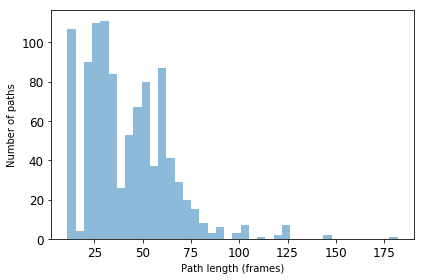

In [14]:
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40, alpha=0.5);
plt.xlabel("Path length (frames)")
plt.ylabel("Number of paths")
#print("Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")")
#print("Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+(np.mean(path_lengths)*engine.snapshot_timestep).format("%.3f")+")")
plt.tight_layout()

#### Path density histogram

Next we will create a path density histogram. Calculating the histogram itself is quite easy: first we reload the collective variables we want to plot it in (we choose the phi and psi angles). Then we create the empty path density histogram, by telling it which CVs to use and how to make the histogram (bin sizes, etc). Finally, we build the histogram by giving it the list of active trajectories to histogram.

In [15]:
from openpathsampling.numerics import HistogramPlotter2D

In [16]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [17]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

In [18]:
%%time

path_dens_counter = path_density.histogram([s.active[0].trajectory for s in flexible.steps])

CPU times: user 25.5 s, sys: 219 ms, total: 25.7 s
Wall time: 26.3 s


Now we've built the path density histogram, and we want to visualize it. We have a convenient `plot_2d_histogram` function that works in this case, and takes the histogram, desired plot tick labels and limits, and additional `matplotlib` named arguments to `plt.pcolormesh`.

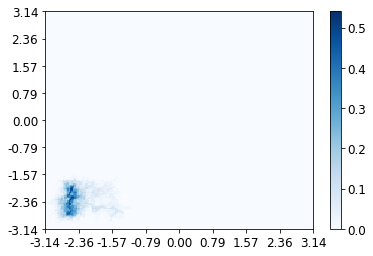

In [19]:
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4)
plotter = HistogramPlotter2D(path_density, 
                             xticklabels=tick_labels,
                             yticklabels=tick_labels, 
                             label_format="{:4.2f}")
ax = plotter.plot(cmap="Blues")